# Sentimental Vasco

Analysis of sentiments expressed in July by the supporters of Vasco da Gama. The sentiments were obtained after scrapped commentaries of a fan website. After that, several models and methods were tried to find the best accuracy (82% with a SGD Classifier).

## Table of Contents
1. Trained model loading
2. How words affect sentiments
3. Sentiments over time

## 1. Trained model loading

The model was previosly trained and saved with joblib. The process used to train the model can be found in /app/model.

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np
from textwrap import wrap

model = joblib.load('../model/vasco_model.sav')
model

SGDClassifier(loss='log_loss', n_jobs=-1, warm_start=True)

## 2. How words affect the sentiments

This is the greatest contribution of the project, as it helps us to understand what the fans value and what the fans despise. The same can be applied to similar projects in product reviews, for example.

### Getting the SGD coefficients

The most straightforward way to discover how each token influenced in the sentiments. 

The data was saved to a CSV where the main tokens were manually 'delemmatized' and punctuation tokens were removed.

In [3]:
# Load the trained model
model = joblib.load('../model/vasco_model.sav')

# Assuming X_df is the DataFrame with the features (tokens)
X_df = pd.read_feather('../model/preprocessed_data/x_new.feather')
tokens = X_df.columns

# Initialize an empty DataFrame to store the importances
importances_df = pd.DataFrame(index=tokens)

sgd_coefficients = model.coef_.flatten()
importances_df['sgd_importance'] = sgd_coefficients

# Sort by importance
importances_df = importances_df.sort_values(by='sgd_importance', ascending=False)

# Filter top positive and negative tokens for plotting
top_pos_tokens = importances_df.head(15)
top_neg_tokens = importances_df.tail(17)

# Combine top positive and negative for plotting
top_tokens = pd.concat([top_pos_tokens, top_neg_tokens])

# top_tokens.to_csv('top_tokens.csv')

## Plotting positive and negative data

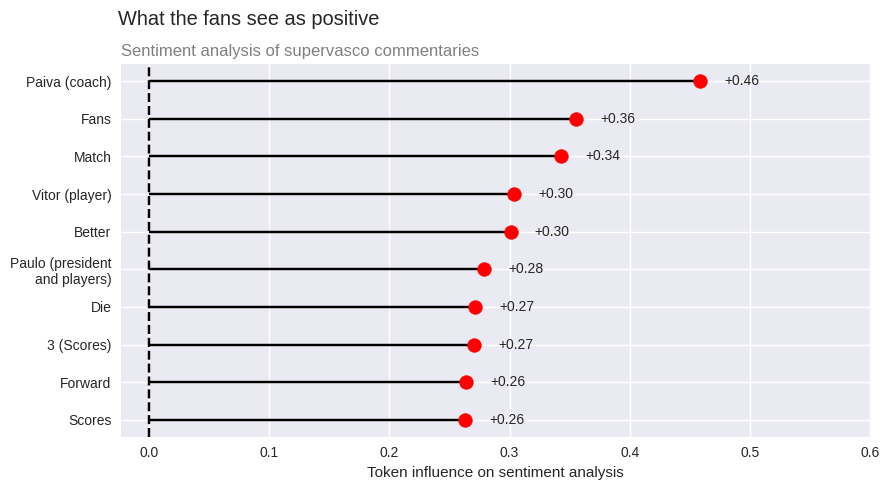

In [298]:
# Load the top tokens importance data
top_tokens = pd.read_csv('top_tokens.csv', index_col=0)


pos_tokens = top_tokens.sort_values(['sgd_importance']).tail(10)

normalized_importance = normalize([np.array(pos_tokens['sgd_importance'])])[0]

labels = [ '\n'.join(wrap(l, 18)) for l in pos_tokens['stemmer_en'] ]


# Plot
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(9, 5))
plt.scatter(normalized_importance, labels, s=100, zorder=2, c='red')
plt.hlines(y=labels, xmin=0, xmax=normalized_importance, zorder=1, colors='black')
for i, v in enumerate(normalized_importance):
    plt.text(v+0.02, i, f"{v:+.2f}", va='center', ha='left')

plt.xticks(np.arange(0, 0.65, 0.1))
plt.rcParams.update({'figure.titlesize': 'x-large'})

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Token influence on sentiment analysis')
plt.suptitle('What the fans see as positive', x=0.282, y=0.97)
plt.title('Sentiment analysis of supervasco commentaries', x=0.239, y=1, c='gray')

plt.tight_layout()

plt.show()

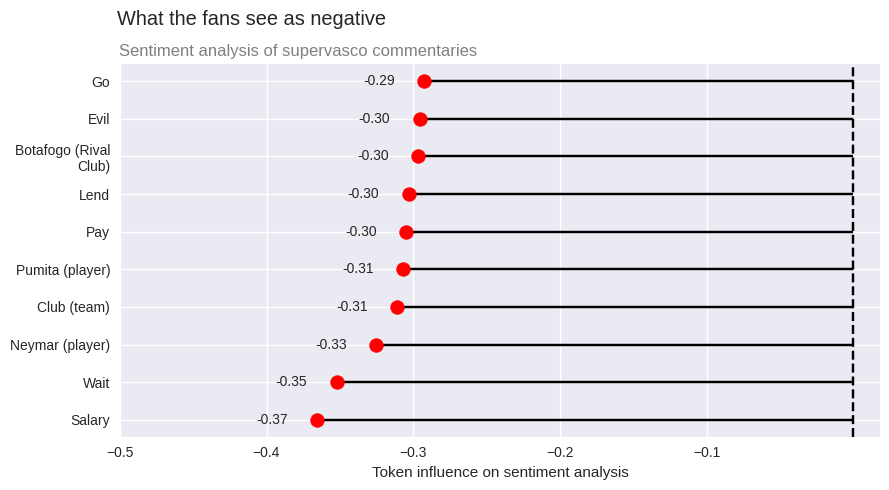

In [297]:
neg_tokens = top_tokens.sort_values(['sgd_importance']).head(10)

normalized_importance = normalize([np.array(neg_tokens['sgd_importance'])])[0]

labels = [ '\n'.join(wrap(l, 18)) for l in neg_tokens['stemmer_en'] ]

# Plot
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(9, 5))
plt.scatter(normalized_importance, labels, s=100, zorder=2, c='red')
plt.hlines(y=labels, xmin=0, xmax=normalized_importance, zorder=1, colors='black')
for i, v in enumerate(normalized_importance):
    plt.text(v-0.02, i, f"{v:+.2f}", va='center', ha='right')

plt.xticks(np.arange(-0.5, 0, 0.1))
plt.rcParams.update({'figure.titlesize': 'x-large'})

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Token influence on sentiment analysis')
plt.suptitle('What the fans see as negative', x=0.285, y=0.97)
plt.title('Sentiment analysis of supervasco commentaries', x=0.234, y=1, c='gray')

plt.tight_layout()

plt.show()

## 3. Sentiments over time

The following plot shows how sentiments behaved over time, also explaining why there was a turn between 2024-07-10 and 2024-07-11. The plot also shows how the model performed against the actual average and how the sentiments are always below a 0.5 threshold (being above it would mean that the fans are happy.).

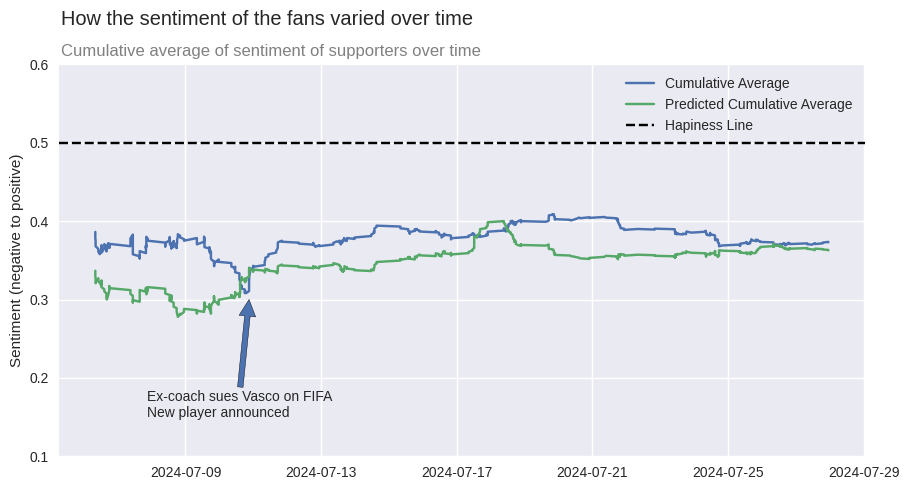

In [234]:
X = pd.read_feather('../model/preprocessed_data/x_new.feather')
y = pd.read_csv('../model/preprocessed_data/y_new.csv')

pages = pd.read_csv('../scrapper/pages.csv', parse_dates=[1])
pages = pages[['new_id', 'datetime']].join(y.set_index('pg_index'), how='right')[['new_id', 'datetime', 'score']].iloc[::-1]
y_pred = model.predict(X)
pages['predicted_score'] = y_pred
cumulative_average = pages[['predicted_score', 'score']].expanding().mean()

cumulative_average = cumulative_average.rename(columns={'predicted_score': 'cum_pred_score', 'score': 'cum_score'})
pages = pd.concat([pages, cumulative_average], axis=1)
pages = pages.iloc[100:]

fig, ax = plt.subplots(figsize=(9, 5))


ax.plot(pages['datetime'], pages['cum_score'], label='Cumulative Average')
ax.plot(pages['datetime'], pages['cum_pred_score'], label='Predicted Cumulative Average')

ax.set_yticks(np.arange(0.1, 0.7, 0.1))

plt.suptitle('How the sentiment of the fans varied over time', x=0.28, y=0.97)
plt.title('Cumulative average of sentiment of supporters over time', x=0.263, c='gray')

ax.axhline(0.5, color='black', linestyle='--', label='Hapiness Line')

ax.legend(loc='upper right')
    
plt.tight_layout()
ax.set_ylabel('Sentiment (negative to positive)')

ax.annotate('Ex-coach sues Vasco on FIFA\nNew player announced',
            xy=(pd.Timestamp('2024-07-11'), 0.3),
            xytext=(pd.Timestamp('2024-07-08'), 0.15),
            arrowprops={})

plt.show()